In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
data = pd.read_excel('DataText.xlsx')

In [ ]:
data

,activity name
0,Юмор Мемуары ценителей научных мемов
1,Юмор мемгу
2,Финансы Рофлы с Волк Стрит
3,Объявления Хабр Карьера
4,Финансы Фиксируем Прибыль
...,...
4295,Городское сообщество ОРЕНБУРГ ОЧЕВИДЕЦ
4296,Книга I N F I N I T Y ?
4297,Творчество ТФП Оренбург | TFP Orenburg
4298,Сайты НОВОТРОИЦК


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   activity name  4299 non-null   object
dtypes: object(1)
memory usage: 33.7+ KB


## Функция для токенизации

In [ ]:
from nltk.tokenize import word_tokenize        # Импорт токенезации слов
from nltk import download as nltk_download     # Паке с токенизатором

nltk_download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
with open ("stop_ru.txt", "r") as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'    
filter = rus_stops + list (punctuation)

--2022-07-21 00:37:25--  https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 5823 (5,7K) [text/plain]
Сохранение в: «stop_ru.txt»

     0K .....                                                 100% 2,84M=0,002s

2022-07-21 00:37:25 (2,84 MB/s) - «stop_ru.txt» сохранён [5823/5823]



In [ ]:
# Установка лематизатора
from pymorphy2 import MorphAnalyzer
parser = MorphAnalyzer()

## Функция предообработки текста
1. Приводим текст к нижнему регистру;
2. Токенизируем его;
3. Выбрасываем слова, которые входят в наш список, объединяющий знаки препинания и стоп-слова;
4. Очищенный токенизированный текст мы лемматизируем — это как раз то, что нужно для тематического моделирования.

In [ ]:
def preprocess(input_text):
    """
    Функция для предобработки текста. Слова приводятся к нижнему регистру,
    стоп-слова удаляются, далее слова лемматизируются
    :param input_text: Входной текст для очистки и лемматизации
    :return: Очищенный и лемматизированный текст
    """
   
    text = input_text.lower()
    tokenized_text = word_tokenize(text)
    clean_text = [word for word in tokenized_text if word not in filter]
    lemmatized_text = [parser.parse(word)[0].normal_form for word in 
                       clean_text]
    
    return lemmatized_text

In [ ]:
# Удалим все числа из данных
data["activity name"] = data["activity name"].astype(str)

In [ ]:
# Применим функцию предобработки текста
data["text_processed"] = data["activity name"].map(preprocess)

### Тематическое моделирование

In [ ]:
import gensim
 
gensim_dictionary = gensim.corpora.Dictionary(data["text_processed"])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
gensim_dictionary.compactify()

### Создадим корпус в виде мешка слов

In [ ]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in data['text_processed']]

### Тематическое моделирование
Установим количество топиков равное 20

In [ ]:
# 20 Топиков 
lda_20 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=20, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

In [ ]:
# 7 топиков
lda_7 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=7, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

In [ ]:
lda_20.print_topics()

[(0,
  '0.445*"образование" + 0.099*"за" + 0.099*"общество" + 0.093*"себя" + 0.078*"уход" + 0.057*"дополнительный" + 0.046*"мир" + 0.023*"школа" + 0.010*"красота" + 0.008*"дизайн"'),
 (1,
  '0.276*"в" + 0.148*"объявление" + 0.134*"рецепт" + 0.105*"кулинария" + 0.097*"автомобиль" + 0.071*"e" + 0.058*"спортивный" + 0.030*"москва" + 0.019*"подслушать" + 0.012*"на"'),
 (2,
  '0.213*"литература" + 0.213*"университет" + 0.133*"программный" + 0.133*"обеспечение" + 0.094*"блогер" + 0.067*"мы" + 0.065*"искусство" + 0.029*"книга" + 0.006*"нижний" + 0.006*"новгород"'),
 (3,
  '0.403*"интернет-сми" + 0.152*"нижний" + 0.144*"новгород" + 0.121*"новость" + 0.077*"школа" + 0.054*"журнал" + 0.006*"красота" + 0.004*"объявление" + 0.004*"и" + 0.003*"москва"'),
 (4,
  '0.459*"группа" + 0.376*"открытый" + 0.052*"музыкальный" + 0.034*"страница" + 0.032*"публичный" + 0.014*"россия" + 0.009*"в" + 0.003*"of" + 0.001*"работа" + 0.001*"и"'),
 (5,
  '0.343*"сообщество" + 0.328*"городской" + 0.070*"типичный" + 0.0

In [ ]:
lda_7.print_topics()

[(0,
  '0.148*"кино" + 0.067*"клуб" + 0.058*"культура" + 0.052*"общество" + 0.051*"за" + 0.049*"себя" + 0.041*"уход" + 0.037*"образование" + 0.037*"фильм" + 0.036*"организация"'),
 (1,
  '0.177*"образование" + 0.063*"объявление" + 0.057*"или" + 0.055*"на" + 0.052*"для" + 0.049*"в" + 0.044*"рецепт" + 0.039*"история" + 0.034*"кулинария" + 0.034*"язык"'),
 (2,
  '0.172*"творчество" + 0.083*"литература" + 0.083*"университет" + 0.063*"нижний" + 0.059*"новгород" + 0.052*"программный" + 0.052*"обеспечение" + 0.048*"шоу" + 0.043*"передача" + 0.043*"the"'),
 (3,
  '0.128*"интернет-сми" + 0.126*"и" + 0.077*"музыка" + 0.073*"наука" + 0.060*"другой" + 0.049*"``" + 0.048*"\'\'" + 0.047*"знакомство" + 0.038*"футбол" + 0.035*"новость"'),
 (4,
  '0.215*"группа" + 0.165*"открытый" + 0.058*"работа" + 0.049*"фотография" + 0.045*"бизнес" + 0.039*"и" + 0.037*"музыкант" + 0.034*"центр" + 0.033*"дизайн" + 0.033*"путешествие"'),
 (5,
  '0.157*"сообщество" + 0.150*"городской" + 0.114*"видеоигра" + 0.053*"жизнь

In [ ]:
# метрика c_v (20 топиков)
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_20,
                                     texts=data["text_processed"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score 20 topics", coherence_lda)


Coherence Score 20 topics 0.500812117706907


In [ ]:
# метрика c_v (7 топиков)
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_7,
                                     texts=data["text_processed"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.5822552835817504


In [ ]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y — значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()

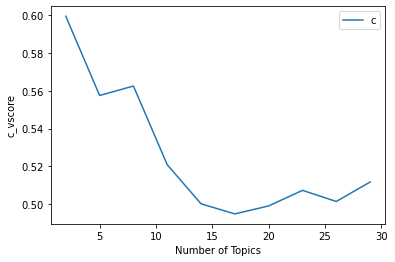

In [ ]:
import matplotlib.pyplot as plt
 
coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=data["text_processed"], start=2, max=30, step=3, measure="c_v")

In [ ]:
# LDA 20 топиков 
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
 
vis_20 = gensimvis.prepare(lda_20, corpus, gensim_dictionary)
pyLDAvis.enable_notebook()
 
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.373174  0.128394       1        1  7.916521
7      0.007375 -0.103240       2        1  6.494544
5      0.006782 -0.206381       3        1  6.277058
10    -0.115748  0.198144       4        1  6.123733
11    -0.046247 -0.073594       5        1  6.032652
0     -0.040868 -0.030233       6        1  6.031346
19    -0.147741  0.203793       7        1  5.252308
14    -0.022331  0.014674       8        1  5.214677
9     -0.039401  0.030965       9        1  5.023344
1     -0.022893 -0.173173      10        1  4.956322
15    -0.117717  0.111287      11        1  4.895796
3      0.016294 -0.175387      12        1  4.794899
17    -0.021991 -0.137036      13        1  4.700875
12    -0.072456  0.015797      14        1  4.658341
16    -0.032131  0.064540      15        1  4.610205
2      0.105866 -0.029555      16        1  4.015656
13    -0.027873 -0.008595      17        1  3.744215
18    -0.025574 -0.104624      18        1  3.623240
6      0.340122  0.106396      19        1  2.983860
8     -0.116641  0.167829      20        1  2.650408, topic_info=             Term        Freq       Total Category  logprob  loglift
32         группа  333.000000  333.000000  Default  30.0000  30.0000
25              и  282.000000  282.000000  Default  29.0000  29.0000
36       открытый  230.000000  230.000000  Default  28.0000  28.0000
5     образование  216.000000  216.000000  Default  27.0000  27.0000
7    интернет-сми  147.000000  147.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
86           игра    0.178097   69.995636  Topic20  -7.0206  -2.3434
5     образование    0.321998  216.481951  Topic20  -6.4283  -2.8803
6               в    0.189281  150.292922  Topic20  -6.9597  -3.0467
106          клуб    0.146091   69.117433  Topic20  -7.2187  -2.5289
12     сообщество    0.152262  166.857496  Topic20  -7.1773  -3.3688

[789 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
66       15  0.967595    ''
67       15  0.967150    ``
122       7  0.113637   art
122       8  0.189395   art
122      18  0.681823   art
...     ...       ...   ...
88        3  0.033012     я
88        5  0.924328     я
74       14  0.950642  язык
74       15  0.024375  язык
123      17  0.936884     •

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 6, 11, 12, 1, 20, 15, 10, 2, 16, 4, 18, 13, 17, 3, 14, 19, 7, 9])

In [ ]:
# LDA 7 топиков 
vis_7 = gensimvis.prepare(lda_7, corpus, gensim_dictionary)
pyLDAvis.enable_notebook()
 
vis_7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.146718 -0.067452       1        1  18.925443
3      0.051736 -0.064347       2        1  14.673815
5     -0.156091  0.150193       3        1  14.571463
1     -0.240037 -0.088508       4        1  14.380405
6      0.286537 -0.104988       5        1  13.257139
0     -0.147078 -0.172014       6        1  13.076871
2      0.058215  0.347115       7        1  11.114864, topic_info=            Term        Freq       Total Category  logprob  loglift
32        группа  332.000000  332.000000  Default  30.0000  30.0000
36      открытый  240.000000  240.000000  Default  29.0000  29.0000
5    образование  230.000000  230.000000  Default  28.0000  28.0000
12    сообщество  175.000000  175.000000  Default  27.0000  27.0000
9      городской  167.000000  167.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
42        работа    1.722075   87.681826   Topic7  -6.1852  -1.7333
125   фотография    0.919724   71.061790   Topic7  -6.8124  -2.1503
25             и    3.591358  284.233876   Topic7  -5.4502  -2.1744
32        группа    1.854246  332.797493   Topic7  -6.1112  -2.9932
36      открытый    1.550347  240.301665   Topic7  -6.2902  -2.8465

[255 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
66        1  0.032619    ''
66        2  0.864403    ''
66        3  0.016309    ''
66        4  0.032619    ''
66        6  0.048928    ''
...     ...       ...   ...
88        5  0.073254     я
88        6  0.087905     я
74        4  0.973757  язык
123       5  0.874542     •
123       7  0.090470     •

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 2, 7, 1, 3])

### Функция назначения более вероятного топика

In [ ]:
def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]

In [ ]:
# Применим функцию к датасету
data["lda_7"] = data["text_processed"].apply(get_topic, lda=lda_7)

In [ ]:
data

,activity name,text_processed,topic_7,probability_7,lda_7
0,Юмор Мемуары ценителей научных мемов,"[юмор, мемуары, ценитель, научный, мем]",5,0.571418,"[5, 0.5714184]"
1,Юмор мемгу,"[юмор, мемгу]",6,0.142857,"[6, 0.14285715]"
2,Финансы Рофлы с Волк Стрит,"[финансы, рофл, с, волк, стрит]",2,0.381046,"[2, 0.38104576]"
3,Объявления Хабр Карьера,"[объявление, хабра, карьера]",1,0.571422,"[1, 0.5714224]"
4,Финансы Фиксируем Прибыль,"[финансы, фиксировать, прибыль]",2,0.571426,"[2, 0.5714262]"
...,...,...,...,...,...
4295,Городское сообщество ОРЕНБУРГ ОЧЕВИДЕЦ,"[городской, сообщество, оренбург, очевидец]",5,0.714284,"[5, 0.7142836]"
4296,Книга I N F I N I T Y ?,"[книга, i, n, f, i, n, i, t, y]",6,0.571094,"[6, 0.5711027]"
4297,Творчество ТФП Оренбург | TFP Orenburg,"[творчество, тфп, оренбург, tfp, orenburg]",2,0.571414,"[2, 0.57141376]"
4298,Сайты НОВОТРОИЦК,"[сайт, новотроицк]",6,0.571425,"[6, 0.57142484]"


In [ ]:
# Разнесем вероятность и топик по разным столбцам
data["topic_7"] = data["lda_7"].str[0]
data["probability_7"] = data["lda_7"].str[1]
del data["lda_7"]

In [ ]:
data

,activity name,text_processed,topic_7,probability_7
0,Юмор Мемуары ценителей научных мемов,"[юмор, мемуары, ценитель, научный, мем]",5,0.571418
1,Юмор мемгу,"[юмор, мемгу]",6,0.142857
2,Финансы Рофлы с Волк Стрит,"[финансы, рофл, с, волк, стрит]",2,0.381046
3,Объявления Хабр Карьера,"[объявление, хабра, карьера]",1,0.571422
4,Финансы Фиксируем Прибыль,"[финансы, фиксировать, прибыль]",2,0.571426
...,...,...,...,...
4295,Городское сообщество ОРЕНБУРГ ОЧЕВИДЕЦ,"[городской, сообщество, оренбург, очевидец]",5,0.714284
4296,Книга I N F I N I T Y ?,"[книга, i, n, f, i, n, i, t, y]",6,0.571103
4297,Творчество ТФП Оренбург | TFP Orenburg,"[творчество, тфп, оренбург, tfp, orenburg]",2,0.571414
4298,Сайты НОВОТРОИЦК,"[сайт, новотроицк]",6,0.571425
